#Örnek: Fren Tasarımı
Bu tasarım probleminde; belirlenen giriş değerlerine karşılık, aracın uygun bir basınç kuvveti ile fren yapabilmesi için basit bir bulanık sistem tasarlanması isteniyor.
<br/>


# Bulanıklaştırıcı

Scikit-Fuzzy kütüphanesinin colab'a yüklenmesi

In [ ]:
!pip install -U scikit-fuzzy

Kütüphanelerin import edilmesi

In [ ]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.membership as mf
import matplotlib.pyplot as plt

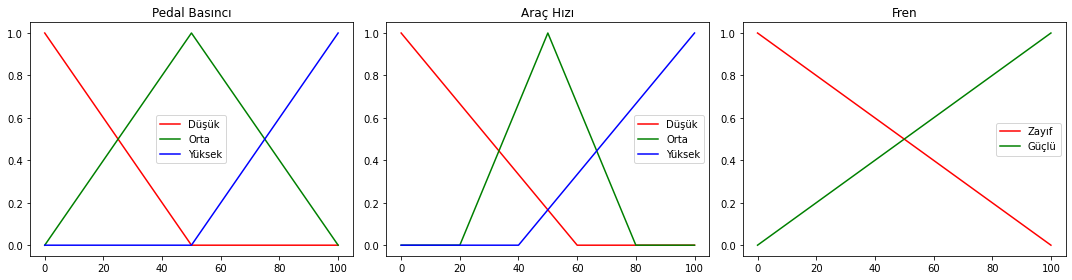

In [ ]:
#@title Üyelik Fonksiyonlarının Tanımlanması
#@markdown Fren sistemini bulanık mantıkla kontrol edebilecek tasarımı gerçekleştirelim.<br>Giriş ve çıkış değerleri aşağıdaki gibi tanımlanmış olsun:<br/><ul><li>Girişler: Pedal Basıncı (%), Araç Hızı (mph)</li><li>Çıkış: Fren (%)</li></ul>Giriş çıkışlar için dilsel değerler de şu şekildedir: <br/><ul><li>Pedal Basıncı: Düşük, Orta, Yüksek</li><li>Araç Hızı: Düşük, Orta, Yüksek</li><li>Fren: Zayıf, Güçlü</li></ul> Pedal basıncı, araç hızı ve fren değişkenlerinin her biri için birer değişken üretiyoruz. NumPy kütüphanesinden ‘arange’ metodu ile her bir değişken için [0, 100] aralığını tanımlıyoruz.

x_pedal=np.arange(0,101,1)
x_speed=np.arange(0,101,1)
x_brake=np.arange(0,101,1)

pedal_low=mf.trimf(x_pedal, [0,0,50])
pedal_med=mf.trimf(x_pedal, [0,50,100])
pedal_hig=mf.trimf(x_pedal, [50,100,100])

speed_low=mf.trimf(x_speed, [0,0,60])
speed_med=mf.trimf(x_speed, [20,50,80])
speed_hig=mf.trimf(x_speed, [40,100,100])

brake_poor=mf.trimf(x_brake, [0,0,100])
brake_strong=mf.trimf(x_brake, [0,100,100])

#@markdown <div>Yanda belirlediğimiz dilsel değerlerin her biri için, üyelik fonksiyonlarını oluşturuyoruz. <b>‘trimf’</b> metodu, triangular membership function yani üçgen üyelik fonksiyonu anlamına gelmektedir. İlk parametresi oluşturulacak değişken için tanım aralığını; ikinci parametresi ise üçgenin başlangıç, orta ve bitiş noktalarını (tanım aralığı üzerinde) belirten birer listeden oluşur. Üçgen üyelik fonksiyonlarını bu şekilde oluşturduk. </div><br> Oluşturduğumuz fonksiyonları, Matplotlib kütüphanesini kullanarak grafiğe dökelim:

fig, (ax0, ax1, ax2)=plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax0.plot(x_pedal, pedal_low, 'r', label='Düşük')
ax0.plot(x_pedal, pedal_med, 'g', label='Orta')
ax0.plot(x_pedal, pedal_hig, 'b', label='Yüksek')
ax0.set_title('Pedal Basıncı')
ax0.legend()

ax1.plot(x_speed, speed_low, 'r', label='Düşük')
ax1.plot(x_speed, speed_med, 'g', label='Orta')
ax1.plot(x_speed, speed_hig, 'b', label='Yüksek')
ax1.set_title('Araç Hızı')
ax1.legend()

ax2.plot(x_brake, brake_poor, 'r', label='Zayıf')
ax2.plot(x_brake, brake_strong, 'g', label='Güçlü')
ax2.set_title('Fren')
ax2.legend()

plt.tight_layout()

In [ ]:
#@title Üyelik Fonksiyonlarının Hesaplanması
#@markdown Giriş değerlerimizi aşağıdaki gibi tanımlayalım:
input_pedal= 27 #@param {type:"slider", min:0, max:100}
input_speed= 57 #@param {type:"slider", min:0, max:100}

#@markdown Belirlediğimiz giriş değerleri için, yukarıda üyelik fonksiyonlarıyla oluşturduğumuz bulanık kümelere olan üyelik derecelerini hesaplayalım:
pedal_fit_low=fuzz.interp_membership(x_pedal, pedal_low, input_pedal)
pedal_fit_med=fuzz.interp_membership(x_pedal, pedal_med, input_pedal)
pedal_fit_hig=fuzz.interp_membership(x_pedal, pedal_hig, input_pedal)

speed_fit_low=fuzz.interp_membership(x_speed, speed_low, input_speed)
speed_fit_med=fuzz.interp_membership(x_speed, speed_med, input_speed)
speed_fit_hig=fuzz.interp_membership(x_speed, speed_hig, input_speed)

# Bilgi Tabanı (Veri tabanı - Kural Tabanı)

In [ ]:
#@title Kuralların Belirlenmesi
#@markdown Belirlenen kurallar ise:<br>
#@markdown -KURAL 1: EĞER Pedal Basıncı Orta İSE, O HALDE Fren Güçlüdür.<br> -KURAL 2: EĞER Pedal Basıncı Yüksek VE Araç Hızı Yüksek İSE, O HALDE Fren Güçlüdür.<br> -KURAL 3: EĞER Pedal Basıncı Düşük VEYA Araç Hızı Düşük İSE, O HALDE Fren Zayıftır.<br> -KURAL 4: Eğer Pedal Basıncı Düşük İSE, O HALDE Fren Zayıftır.<br>
#then (fuzzy imlication) , or/and(t-conorm, tnorm)
#@markdown <br><b>t-norm (VE)</b><br>gödel=min{a,b}<br>product=a.b<br>Łukasiewicz=max{0, a+b-1}
#@markdown <br><b>t-conorm (VEYA)</b><br>Maximum t-conorm=max{a,b}<br>Probabilistic sum=a+b - a.b <br>Bounded sum = min={a+b,1}
rule1=fuzz.relation_min(pedal_fit_med, brake_strong)[0]
rule2=fuzz.relation_min(np.fmin(pedal_fit_hig, speed_fit_hig), brake_strong)[0]
rule3=fuzz.relation_min(np.fmax(pedal_fit_low, speed_fit_low), brake_poor)[0]
rule4=fuzz.relation_min(pedal_fit_low, brake_poor)[0]










#@markdown <p>NumPy kütüphanesine ait ‘fmax’ ve ‘fmin’ metotları, elemanter düzeyde karşılaştırma yaparak, listelerin minimum ve maksimum elemanlarını bulan metotlardır. Örneğin; [1, 2, 5] ve [2, 0, 3] listeleri fmin metoduna verilirse, bu metodun döndürdüğü yeni liste [1, 0, 3] şeklinde olur. Yani; her bir elemanı, eş sıralı diğer elemanla karşılaştırıp min yada max olanı hesaplıyorlar. Burada ise, bulanık mantık kullanımında anlamlı olması açısından; <b>fmax</b> metodunu veya bağlacı yerine, <b>fmin </b>metodunu da ve bağlacı yerine kullanıyoruz. En dışarıda <b>relation_min</b> metodunu kullanmamız da bir implicasion işlemidir yani kuralda belirtilen THEN(O HALDE) kavramını temsil etmektedir. </p>

# Bulanık Çıkarım

Text(0.5, 1.0, 'Fren Çıkışı')

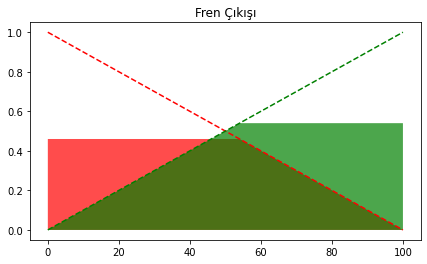

In [ ]:
#@title Çıkarımın Hesaplanması
#@markdown İlgili girişlere göre hesaplanan kural çıkışlarını, aşağıdaki gibi fmax metoduna veriyoruz. Burada amaçladığımız şey, aynı çıkışı veren bulanık kümelerin <b>birleşim kümesini</b> hesaplamaktır.
out_strong=np.fmax(rule1, rule2)
out_poor=np.fmax(rule3, rule4)

brake0=np.zeros_like(x_brake)

fig, ax0=plt.subplots(figsize=(7,4))
ax0.fill_between(x_brake, brake0, out_poor, facecolor='r', alpha=0.7)
ax0.plot(x_brake, brake_poor, 'r', linestyle='--')
ax0.fill_between(x_brake, brake0, out_strong, facecolor='g', alpha=0.7)
ax0.plot(x_brake, brake_strong, 'g', linestyle='--')
ax0.set_title('Fren Çıkışı')


# Durulaştırma

Fren değişkeni için hesaplanan çıkış değeri: 0.5199573333333336


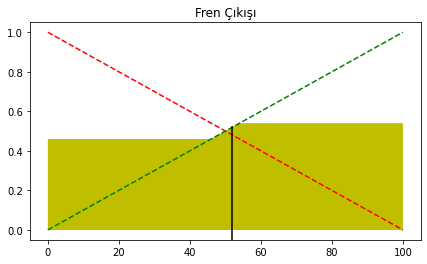

In [ ]:
#@title Berraklaştırma
#@markdown Son aşama olarak durulaştırma işlemine geçiyoruz. Öncelikle, çıkış kümeleri üzerinde gösterilen alanların yine fmax metodunu ile birleşimini hesaplayalım ve bir tek çıkış kümesi şeklinde durulaştırma fonksiyonuna devredelim.<br>‘out_brake’, çıkış kümemizin son halidir. ‘defuzz’ metodu ise, durulaştırma fonksiyonudur. Birinci parametre çıkış değişkeninin tanım aralığını, ikinci parametre giriş değerleriyle elde edilen alanı, üçüncü parametre ise durulaştırma yöntemini belirtir. <b>‘centroid’</b> yöntemi ağırlık merkezi yöntemidir.  <b>‘defuzzified’</b> değişeni, artık bulanık sistemden son çıkan durulaşmış değeri tutmaktadır. ‘result’ değişkeni ise, hesaplanan ağırlık merkezinin tam olarak hangi üyelik derecesine denk geldiğini tutmaktadır. Çıkış değeri ve grafik üzerinde gösterimi ise aşağıdaki gibidir:
out_brake=np.fmax(out_poor, out_strong)
defuzzified=fuzz.defuzz(x_brake, out_brake, 'centroid')
result=fuzz.interp_membership(x_brake, out_brake, defuzzified)

fig, ax0=plt.subplots(figsize=(7,4))
ax0.fill_between(x_brake, brake0, out_poor, facecolor='y')
ax0.plot(x_brake, brake_poor, 'r', linestyle='--')
ax0.fill_between(x_brake, brake0, out_strong, facecolor='y')
ax0.plot(x_brake, brake_strong, 'g', linestyle='--')
ax0.axvline(x=defuzzified, ymax=result, c='k')
ax0.set_title('Fren Çıkışı')

print('Fren değişkeni için hesaplanan çıkış değeri: '+ str(result))